In [26]:
%matplotlib inline
import graphlab
import graphlab.aggregate as agg
import numpy as np
import matplotlib.pyplot as plt  
import string
from stop_words import get_stop_words

stopwords = set(get_stop_words('en'))

plt.style.use('ggplot')

In [2]:
sf = graphlab.SFrame('./data/boardgames-comments')

[INFO] 1443469892 : INFO:     (reap_unused_temp_files:277): Deleting orphaned temp directory found in C:\Users\David\AppData\Local\Temp\graphlab-David\36640
This non-commercial license of GraphLab Create is assigned to djwelch666@googlemail.comand will expire on September 24, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-50168 - Server binary: c:\users\david\.virtualenvs\py\lib\site-packages\graphlab\unity_server.exe - Server log: C:\Users\David\AppData\Local\Temp\graphlab_server_1443469892.log.0
[INFO] GraphLab Server Version: 1.6.1


In [3]:
sf = sf[sf['rating'] != 'null']
sf.add_column(sf.select_column('rating').apply(lambda x: float(x)), 'rating_float')
sf.remove_column('rating')
sf['rating'] = sf['rating_float']
sf.remove_column('rating_float')
sf['word_count'] = graphlab.text_analytics.count_words(sf['text'])
sf['ngram_count'] = graphlab.text_analytics.count_ngrams(sf['text'])

In [36]:
sf['text_no_stopwords'] = sf.select_column('text').apply(lambda x: string.join([w.lower() for w in x.split() if w not in stopwords]))

In [38]:
sf['word_count'] = graphlab.text_analytics.count_words(sf['text_no_stopwords'])

In [39]:
word_counts = {}
for wc in sf['word_count']:
    for key, value in wc.items():
        word_counts[key] = (word_counts[key] if key in word_counts else 0) + value

In [5]:
ngram_counts = {}
for wc in sf['ngram_count']:
    for key, value in wc.items():
        ngram_counts[key] = (ngram_counts[key] if key in ngram_counts else 0) + value

In [40]:
word_counts_sf = graphlab.SFrame({'word': [ k for k, v in word_counts.items()], 'count': [ v for k, v in word_counts.items()] })
word_counts_sf.head(2)

count,word
1,pleaser!
1,elbaltázott


In [8]:
ngram_counts_sf = graphlab.SFrame({'ngram': [ k for k, v in ngram_counts.items()], 'count': [ v for k, v in ngram_counts.items()] })
ngram_counts_sf.head(2)

count,ngram
1,contry you
1,lake geography


In [41]:
word_counts_sf.sort('count', False)

count,word
351314,i
343054,game
144450,the
126851,game.
118024,play
105359,like
93508,one
86294,can
82262,good
74103,fun


In [20]:
set(['a', 'hlksjdf']) - set(stopwords)

{'hlksjdf'}

In [ ]:
sf.head()

In [ ]:
sf.groupby(key_columns='boardgameid', operations={ 'count': agg.COUNT() }).topk('count', 10)

In [ ]:
names = graphlab.SFrame('./data/boardgames-names')

In [ ]:
names[names['id'] == 2651]

In [48]:
reviews = data[data['boardgameid'] == 2651]

In [ ]:
reviews_agg = reviews.groupby(key_columns='rating', operations={ 'count': agg.COUNT() })
reviews_agg.sort('rating', False)

X = reviews['rating']
bins = np.arange(10)
plt.hist(X, bins, normed=1, histtype='bar', rwidth=0.8)
plt.title('Reviews')

In [ ]:
X = sf['rating']
bins = np.arange(10)
plt.hist(X, bins, normed=1, histtype='bar', rwidth=0.8)
plt.title('All Reviews')

In [43]:
data = sf[(sf['rating'] >= 6) | (sf['rating'] < 5)]

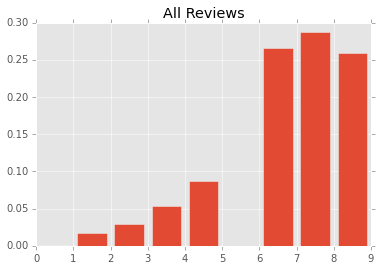

In [44]:
X = data['rating']
bins = np.arange(10)
plt.hist(X, bins, normed=1, histtype='bar', rwidth=0.8)
plt.title('All Reviews')

In [45]:
data['sentiment'] = data['rating'] >= 6

In [58]:
train_data, test_data = data.random_split(0.8, seed=0)

In [47]:
sentiment_model = graphlab.logistic_classifier.create(train_data, 
                                                      target='sentiment', features=['word_count'], validation_set=test_data)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 431490
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 421875
PROGRESS: Number of coefficients    : 421876
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 4        | 0.000001  | 2.296617     | 0.825189          | 0.821275            |
PROGRESS: | 2         | 8        | 3.000000  | 3.887737     | 0.907379          | 0.854610            |
PROGRESS: | 3         | 9        | 3.000000  | 4.520183     | 0.92

In [53]:
len(data[data['sentiment'] == 1])/float(len(data))

0.8216720195224708

In [ ]:
sentiment_model.evaluate(test_data, 'roc_curve')

In [49]:
reviews['predicted_sentiment'] = sentiment_model.predict(reviews, output_type='probability')

In [50]:
reviews = reviews.sort('predicted_sentiment', False)

In [52]:
reviews.head()

boardgameid,text,username,rating,word_count
2651,Solid German game. Ithink the theme is be ...,a2greg,6.5,"{'saying': 1L, 'just':1L, 'golden': 1L, ..."
2651,I've read a lot that 2player is the worst way ...,Adam78,9.0,"{'accessible.': 1L,'think': 1L, 'love': 1L, ..."
2651,"Juego de subastas decentrales eléctricas, ...",Adanedhel,8.1,"{'el': 7L, 'en': 2L,'incluso': 1L, 'cartas': ..."
2651,This game completely doesit for me... it's the ...,acetate3,9.0,"{'economics,': 1L,'this': 1L, 'love': 3L, ..."
2651,Several clever playmechanics mesh together ...,Actherion,9.0,"{'mechanics': 1L,'fairly': 2L, 'almost': ..."
2651,"Strong theme, solidstrategy game that ru ...",4Corners,7.0,"{'own': 1L,'cards[/boardgame],': ..."
2651,"Power Grid is a goodgame, and I can see why ...",AdmiralACF,6.5,"{'all': 1L, 'since': 1L,'played': 2L, 'consid ..."
2651,Love the game. Greatfun. Great interaction ...,ab999,9.0,"{'set': 1L, 'love': 1L,'carefully': 1L, 'need': ..."
2651,"The godfather of theeconomic simulation, ...",39Daleks,10.0,"{'particularly': 1L,'bidding': 1L, 'long,': ..."
2651,A blast with 5 players.Only drawback seems t ...,Acenoid,8.5,"{'sometimes': 1L, ':)':1L, 'seems': 1L, 'move': ..."


In [ ]:
reviews[-1]['text']

In [ ]:
reviews[-2]

In [55]:
single_words = set(word_counts_sf[word_counts_sf['count'] == 1]['word'])

In [56]:
def del_one(x):
    for k, v in x.items():
        if k in single_words:
            del x[k]
    return x
#sf.remove_column('word_count_no_ones')
data.add_column(data.select_column('word_count').apply(lambda x: del_one(x)), 'word_count_no_ones')

boardgameid,text,username,rating,word_count
26717,Fascinating approach tothe different technology ...,armyduck95,7.0,"{'control': 1L,'warfare.': 1L, 'play': ..."
26717,"In this modern version,Tech Level differenti ...",hnishy63,6.0,"{'breaking': 1L, 'give':1L, 'there': 1L, ..."
26717,Good modern platoon levelrules ...,JohnHBiedenkapp,9.0,"{'rules': 1L, 'good': 1L,'modern': 1L, 'platoon': ..."
26718,This game is well-designed for a Monopoly ...,espoon82,6.0,"{'this': 1L, 'just': 2L,'variant.': 1L, 'nhl': ..."
26718,I have not played thisversion of Monopoly. My ...,The Unbeliever,4.0,"{'desire': 1L, 'rating':1L, 'play': 1L, ..."
26721,Public Domain card game.,Nap16,4.0,"{'game.': 1L, 'domain':1L, 'public': 1L, 'ca ..."
26721,Three player Huutopussitakes forever but four ...,oskari,6.0,"{'entertaining.': 1L,'forever': 1L, 'takes': ..."
26721,To quote a phrase used bycard historian David ...,sundaysilence,6.0,"{'the': 1L, 'tacked': 1L,'because': 1L, 'force': ..."
26722,"Playing a game with 6people, so have two ...",Insane Foxx,9.0,"{'her""': 1L, '""no,': 1L,'rest': 1L, '""arn\'t': ..."
26722,I played this game oncewith the original ...,larienna,4.0,"{'think': 1L, 'closely':1L, 'designer.': 1L, ..."


In [59]:
no_ones_sentiment_model = graphlab.logistic_classifier.create(train_data, 
                                                      target='sentiment', features=['word_count_no_ones'],
                                                      validation_set=test_data)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 431490
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 1
PROGRESS: Number of unpacked features : 181445
PROGRESS: Number of coefficients    : 181446
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 4        | 0.000001  | 1.130785     | 0.822918          | 0.821275            |
PROGRESS: | 2         | 8        | 3.000000  | 2.565794     | 0.888632          | 0.856985            |
PROGRESS: | 3         | 9        | 3.000000  | 3.139198     | 0.90

In [ ]:
data['ngram_count'] = graphlab.text_analytics.count_ngrams(data['text'])

In [ ]:
ngram_sentiment_model = graphlab.logistic_classifier.create(train_data, 
                                                      target='sentiment', features=['ngram_count'],
                                                      validation_set=test_data)

In [60]:
reviews['predicted_no_ones_sentiment'] = no_ones_sentiment_model.predict(reviews, output_type='probability')

In [61]:
reviews = reviews.sort('predicted_no_ones_sentiment', False)

In [62]:
reviews

boardgameid,text,username,rating,word_count
2651,Excellent game althoughit gets a bit too mathy ...,abnormallyramsey,7.0,"{'enjoy': 1L, 'manager':1L, 'sparks': 1L, 'ga ..."
2651,29 Devons,addamaniac,8.0,"{'29': 1L, 'devons': 1L}"
2651,It's the only top tengame I did not tend to ...,aandjso,9.0,"{'outlook': 1L, 'now':1L, '(the': 1L, 'ten': ..."
2651,Really enjoy the strategyto this game. Don't t ...,AdmiralGT,10.0,"{'enjoy': 1L,'criticism': 1L, ""don ..."
2651,"Great game, have funevery time we play. ...",Adonai_80,7.0,"{'great': 1L, 'game,':1L, 'every': 1L, 'time': ..."
2651,Rating may change intime.\n\nA real thinker. ...,Admiral Fisher,7.0,"{'mathematical': 1L,'rating': 1L, 'here.': ..."
2651,reviewed on my blog as'Funckenschlag/Power ...,5th Beatles,6.0,"{'blog': 1L,""'funckenschlag/power"": ..."
2651,"I really enjoy PowerGrid. The auctions, ...",ackman,10.0,"{'enjoy': 1L, 'grid.':1L, 'tough': 1L, 'pow ..."
2651,There is nothing likeagonizing about how much ...,aarondesk,9.0,"{'plants.': 1L,'opponents,': 1L, 'li ..."
2651,I kind of love how uglythis game is. The one ...,AdamCurtis,7.0,"{'kind': 1L, 'love': 1L,'lead': 2L, 'i': 2L, ..."
